In [1]:
###Sys block
from warnings import simplefilter
simplefilter(action = 'ignore')
from random import seed
seed(120622)

###Lib block
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sbn
from random import gauss, uniform
import ray as rClust
from tqdm import tqdm

## FitzHugh-Nagumo neuron model

### System of differential equations

$$\frac{dv}{dt} = v - \frac{v^{3}}{3} - w + ri$$

$$\frac{dw}{dt} = \frac{v + a - bw}{\tau}$$

## DIRECTIONS:

1. Build FitzHugh-Nagumo neuron model with provided mathematical formalism (above) and parameterization (below), following the generic code architecture provided below.
2. Total simulation time should be equal to 1000 ms, and the dt should be equal to 0.025 ms.
3. Initial conditionals of state variables can be set to 0.5.
4. Utilize a simple forward Euler integrator.
5. Use the pandas .query() method to filter data according to time column-vector, only keeping data where time is >= 900 ms.
6. Ensure your code underneath the #I.O comment renders head of df.
7. Visualize simulated neuronal activity using pyplot.

In [14]:
###Main block
#Modl params
r, i_ = 0.1, 5
a, b, tau = 0.7, 0.8, 12.5

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, w = sVars
    
    #Compute RHS of ODEs
    dvdt = v - (v ** 3 / 3) - w + r * i_
    dwdt = (v + a - b * w) / tau

    #Fxn I.O
    return(np.array([dvdt, dwdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,900.000,-0.976332
1,900.025,-0.974416
2,900.050,-0.972494
3,900.075,-0.970564
4,900.100,-0.968629


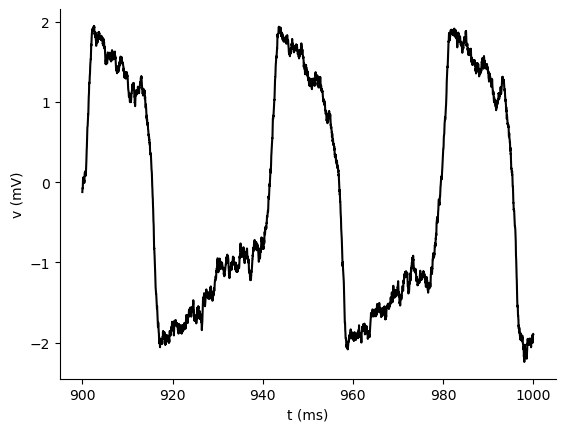

In [20]:
#Visualization
plt.figure()
plt.plot(data['t'], 
         data['v'],
         color = 'black')
sbn.despine()
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.show()

## FitzHugh-Nagumo model compared to biological oscillator

## DIRECTIONS:

1. Read in biological burster data using pandas. The relative path you should pass to the read_csv pandas' method is: './data/biologicalBurster.csv'
2. Visualize model and biological data using subplot() pyplot approach.
3. Figure size, the arg for which is figsize and can be passed to the .figure() pyplot method as a tuple, should be (12, 5).
4. For each subplot, you can also turn axes off with plt.axis('off').

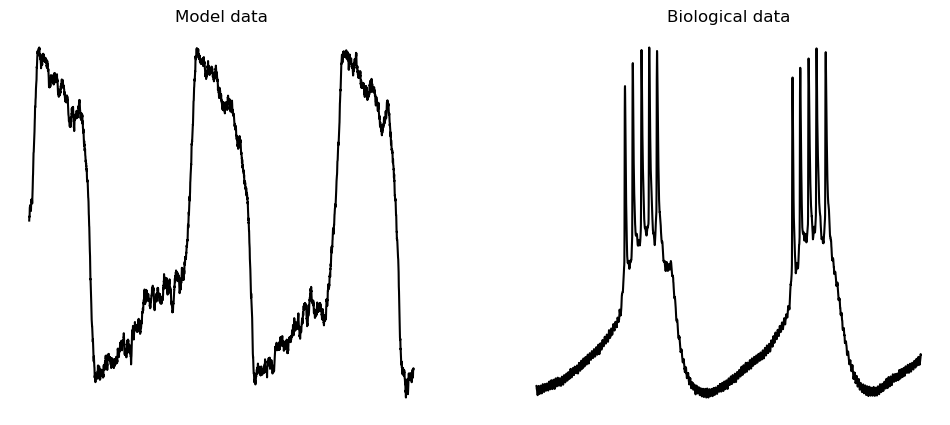

In [21]:
#Data dump
biolData = pd.read_csv('../data/biologicalBurster.csv')

##Visualization
#Creation of graphics device
plt.figure(figsize = (12, 5))

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         color = 'black')
plt.title('Model data')
plt.axis('off')


#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Render visualization to jupyter
plt.show()

## FitzHugh-Nagumo model with noise compared to biological oscillator

### Voltage-representing, state-variable equation with additive noise

$$\frac{dv}{dt} = v - \frac{v^{3}}{3} - w + \xi + ri$$

## DIRECTIONS:

1. Recapitulate above-constructed FitzHugh-Nagumo neuron model with additive, pseudo-levy noise as expressed in above mathematical description. Use already import gauss function with mean (mu arg) and std (sigma arg) equal to 0 and 1, respectively.
2. Visualize just as you did above.

In [15]:
###Main block
#Modl params
r, i_ = 0.1, 5
a, b, tau = 0.7, 0.8, 12.5

#Run controls
time, dt = 1000, 0.025
n = time / dt
t = np.arange(0 + dt, time, dt)

#DAQ tensor instantiation
sVars = np.zeros((int(n), 2))

#Initialization
sVars[0] = np.array([0.5, 0.5])

#Helper fxns (eqns)
def dfdt(sVars):
    #Unpack state vars
    v, w = sVars
    
    #Compute RHS of ODEs
    dvdt = v - (v ** 3 / 3) - w + gauss(mu = 0, sigma = 1) + r * i_
    dwdt = (v + a - b * w) / tau

    #Fxn I.O
    return(np.array([dvdt, dwdt]))

#Integrate using forward-Euler formalism
for i,_ in enumerate(t):
    sVars[i + 1] = sVars[i] + dt * dfdt(sVars[i])
    
#Package vectors in nd heterogenous df
data = pd.DataFrame({'t': np.insert(t, 0, 0),
                     'v': sVars[:, 0]}) \
         .query('t >= 900') \
         .reset_index(drop = True)

#I.O
data.head()

,t,v
0,900.000,-0.122342
1,900.025,-0.098148
2,900.050,-0.072203
3,900.075,-0.077944
4,900.100,-0.075422


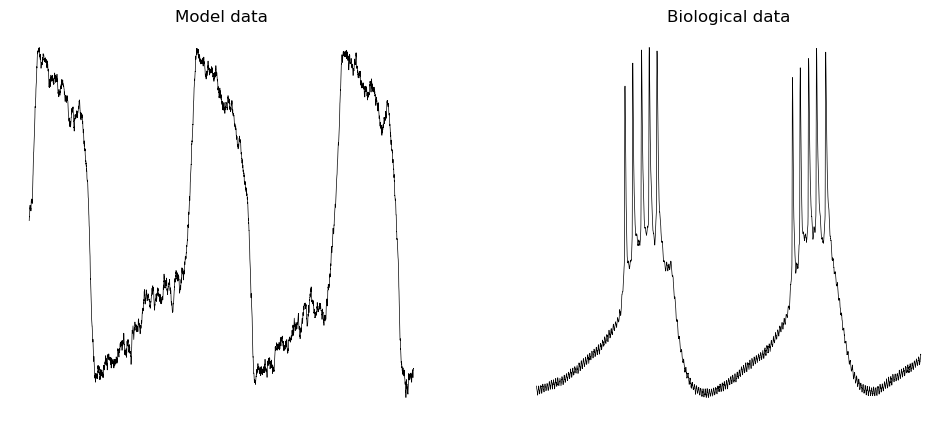

In [17]:
##Visualization
#Creation of graphics device
plt.figure(figsize = (12, 5))

#Creation of first panel (model data)
plt.subplot(121)
plt.plot(data['t'], 
         data['v'],
         linewidth = 0.5,
         color = 'black')
plt.title('Model data')
plt.axis('off')

#Creation of second panel (biological data)
plt.subplot(122)
plt.plot(biolData['t'], 
         biolData['v'],
         linewidth = 0.5,
         color = 'black')
plt.title('Biological data')
plt.axis('off')

#Draw visualization to jupyter
plt.show()

## Random parameter search in series

### Functionalize FitzHugh-Nagumo model

## DIRECTIONS:

1. Functionalize recapitulated neuron model above (i.e., the one that includes the additive, pseudo-Levy noise process).
2. Ensure i_ is a parg/kwarg and is removed from local function scope.
3. Simulate functionalized model, rendering head of df where i_ = 5.

In [7]:
###Fxn block
def fnModl(i_):
    '''
    
    Fxnalized FitzHugh-Nagumo modl object
    
    - Modl param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    r = 0.1
    a, b, tau = 0.7, 0.8, 12.5
    
    #Run controls
    
    #DAQ tensor instantiation
    
    #Initialization
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
    
        #Compute RHS of ODEs
    
        #Fxn I.O
        return(np.array([dvdt, dwdt]))
    
    #Integrate using forward-Euler formalism
    for i,_ in enumerate(t):
        
    #Package vectors in nd heterogenous df
    
    #I.O

###Main block
#Compute modl results


,t,v
0,900.000,0.068735
1,900.025,0.067470
2,900.050,0.069108
3,900.075,0.036323
4,900.100,0.045448


### Subject FitzHugh-Nagumo model to random parameter search

$$i \in [5, 15]$$

#### Benchmark serial execution

## DIRECTIONS:

NOTE: Refer to similar section in week3 solutionsNotebook.ipynb

1. Use magic cell function %%time to benchmark computational performance of serial execution of simulating neuron models.
2. Utilize tqdm() around iterable to produce progress bar.
3. Use pandas' .concat() method to append nested data structures in list-column to df column-wise.
4. Ensure your code underneath the #I.O comment renders head of df.
5. Visualize data using control loop (i.e., a for loop) where iterable is panel constructor.
6. Figure size, the arg for which is figsize and can be passed to the .figure() pyplot method as a tuple, should be (12, 8).

In [8]:
###Main block
#Declare number of neurons to simulate

#DAQ list-column instantiation


In [9]:


#Compute modl outputs subject to Monte-Carlo param (i_) selection
for i in tqdm(range(nNeurons + 1)):
    #Conditionally capture t and x for first iteration
    if i == 0:

    #Conditionally capture x for remainder of iterations
    else:


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.31it/s]

Wall time: 3.03 s


In [10]:
#Transform to nd heterogenous df

#I.O


,t,v,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,900.000,1.800094,-1.903939,-1.111186,1.747864,1.769603,-1.783899,-1.597023,-1.789782,0.610287,-1.516832
1,900.025,1.806699,-1.855577,-1.142439,1.728474,1.779656,-1.777489,-1.593405,-1.796936,0.624799,-1.514193
2,900.050,1.800500,-1.853797,-1.139791,1.736089,1.824558,-1.803583,-1.636467,-1.780470,0.627458,-1.512595
3,900.075,1.794874,-1.895894,-1.165723,1.763827,1.813730,-1.807803,-1.692481,-1.807098,0.634164,-1.522565
4,900.100,1.765979,-1.906658,-1.149809,1.721451,1.841586,-1.765980,-1.678076,-1.826273,0.604060,-1.517394


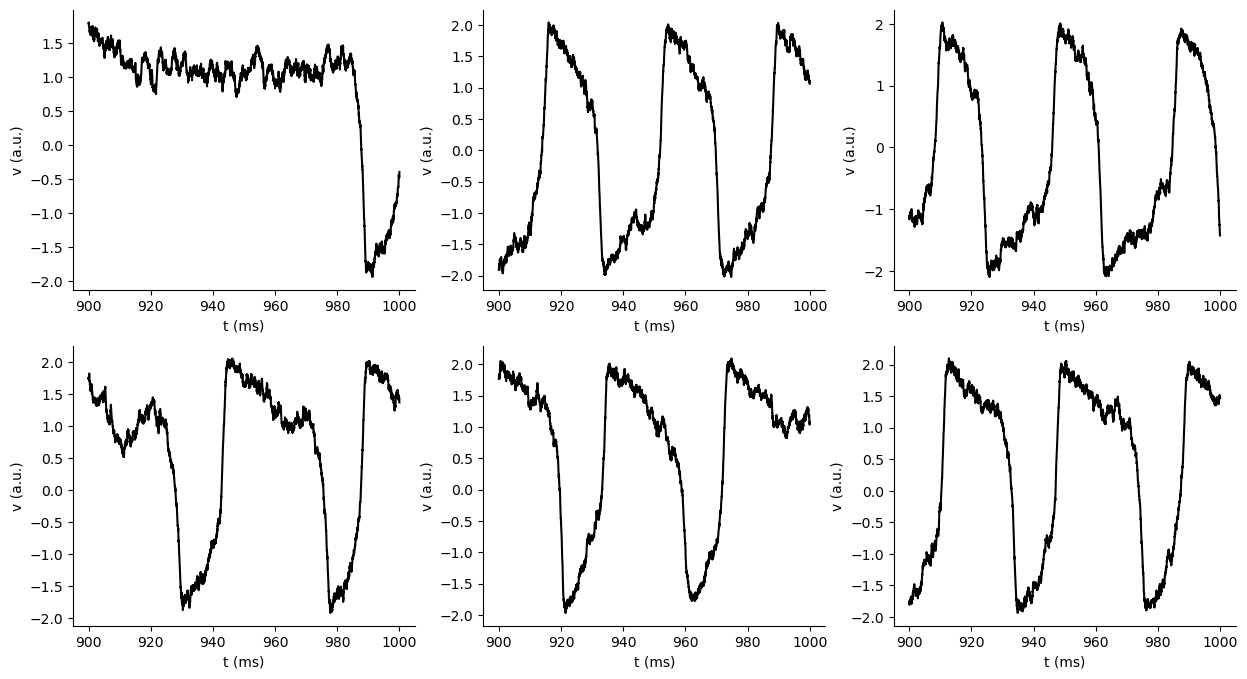

In [11]:
##Visualization
#Creation of graphics device

#Creation of iterable
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):

#Alter graphics device attributes

#Render visualization to jupyter


## Random parameter search in parallel

### Functionalize FitzHugh-Nagumo model with ray cluster decorator

## DIRECTIONS:

1. Functionalize recapitulated neuron model above (i.e., the one that includes the additive, pseudo-Levy noise process) using ray decorator.
2. Ensure i_ is a parg/kwarg and is removed from local function scope.

In [12]:
###Fxn block
@rClust.remote
def fnModl(i_):
    '''
    
    Fxnalized FitzHugh-Nagumo modl object decorated with ray cluster functionality for parallelization
    
    - Model param is now fxn arg
        * i_ is parg/kwarg
        * all other args locally scoped
    
    '''
    
    #Modl params
    r = 0.1
    a, b, tau = 0.7, 0.8, 12.5
    
    #Run controls
    
    #DAQ tensor instantiation
    
    #Initialization
    
    #Helper fxns (eqns)
    def dfdt(sVars):
        #Unpack state vars
    
        #Compute RHS of ODEs
    
        #Fxn I.O
        return(np.array([dvdt, dwdt]))
    
    #Integrate using forward-Euler formalism
    for i,_ in enumerate(t):
        
    #Package vectors in nd heterogenous df
    
    #I.O


### Subject FitzHugh-Nagumo model to random parameter search

$$i \in [5, 15]$$

#### Benchmark parallel execution

## DIRECTIONS:

NOTE: Refer to similar section in week3 solutionsNotebook.ipynb

1. Use magic cell function %%time to benchmark computational performance of serial execution of simulating neuron models.
2. Utilize tqdm() around iterable to produce progress bar.
3. Use pandas' .concat() method to append nested data structures in list-column to df column-wise.
4. Ensure your code underneath the #I.O comment renders head of df.
5. Visualize data using control loop (i.e., a for loop) where iterable is panel constructor.
6. Figure size, the arg for which is figsize and can be passed to the .figure() pyplot method as a tuple, should be (12, 8).

In [13]:
###Main block
#Declare number of neurons to simulate

#Invocation of ray cluster instance


2023-07-24 14:55:32,153	INFO worker.py:1636 -- Started a local Ray instance.


Python version:,3.9.13
Ray version:,2.5.1


In [14]:


##Capture simulative data from parallel subprocesses using list comprehension
#.remote() async assigns nodes/workers in pool task (i.e., computable fxn); creates a future
#.get() sync (i.e., blockingly) retrieves results from nodes/works upon task completion 


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 583.17it/s]


Wall time: 2.72 s


In [15]:
#Shutdown instantiation of local ray instance

##Package vectors in nd heterogenous df
#Remove 't' duplicates

#Alter df column names

#I.O


,t,v,v1,v2,v3,v4,v5,v6,v7,v8,v9
0,900.000,1.719486,1.687993,-1.124773,-0.997257,1.688272,1.182764,1.798868,1.780322,-1.731576,-1.124631
1,900.025,1.679292,1.647844,-1.159627,-1.033148,1.648121,1.143958,1.758283,1.739806,-1.788545,-1.160750
2,900.050,1.679100,1.647591,-1.156000,-1.030821,1.647867,1.143663,1.757975,1.739503,-1.804243,-1.158395
3,900.075,1.662338,1.630772,-1.168872,-1.044991,1.631046,1.126854,1.741084,1.722619,-1.835467,-1.172546
4,900.100,1.666390,1.634728,-1.161457,-1.038983,1.635002,1.130293,1.745105,1.726625,-1.844642,-1.166414


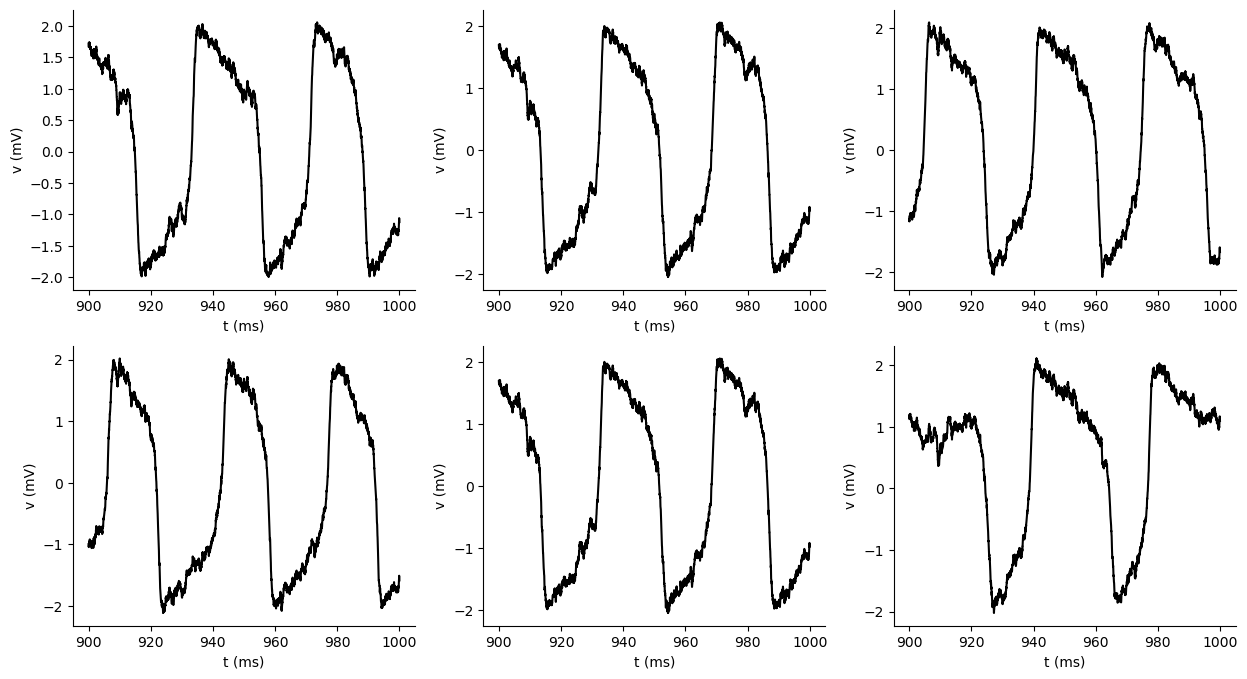

In [16]:
##Visualization
#Creation of graphics device

#Creation of iterables
sp = [231, 232, 233, 234, 235, 236]

#Construct iteratively each panel
for i, val in enumerate(sp):

#Alter graphics device attributes

#Render visualization to jupyter
